<center><h1>BMIF804</h1>
    <h2>Assignment 3</h2>  
    <h3>By: Hannah Driver (10090525)</h3>
    <h4>https://github.com/hannahdriver/BMIF804_Assignment3</h4></center>

<b>This program...</b>

In [2]:
# import libraries
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%config Completer.use_jedi = False

<h2>Data Preparation</h2>

In [3]:
def readImage(imageName):
    """
    Read in file to create image object
    :param imageName: name of the file to read in
    :return: image object
    """
    image = sitk.ReadImage(imageName)
    return image

In [4]:
#read in images and name them

img = readImage('new_prostate.tif')
img_name = "Prostate Image"
#img = sitk.Cast(img, sitk.sitkFloat64)

img2 = readImage('new_segemnt.tif')
img2_name = "Segment Image"

In [5]:
#Set up the 3D Slicer external viewr
external_viewer = sitk.ImageViewer()
slicer_app_location = "C:\\Program Files\\Slicer 4.8.1\\Slicer.exe"
external_viewer.SetApplication(slicer_app_location)

<h2>Part 1</h2>

<h5>Part 1a</h5>

Prostate image as viewed in 3D Slicer:

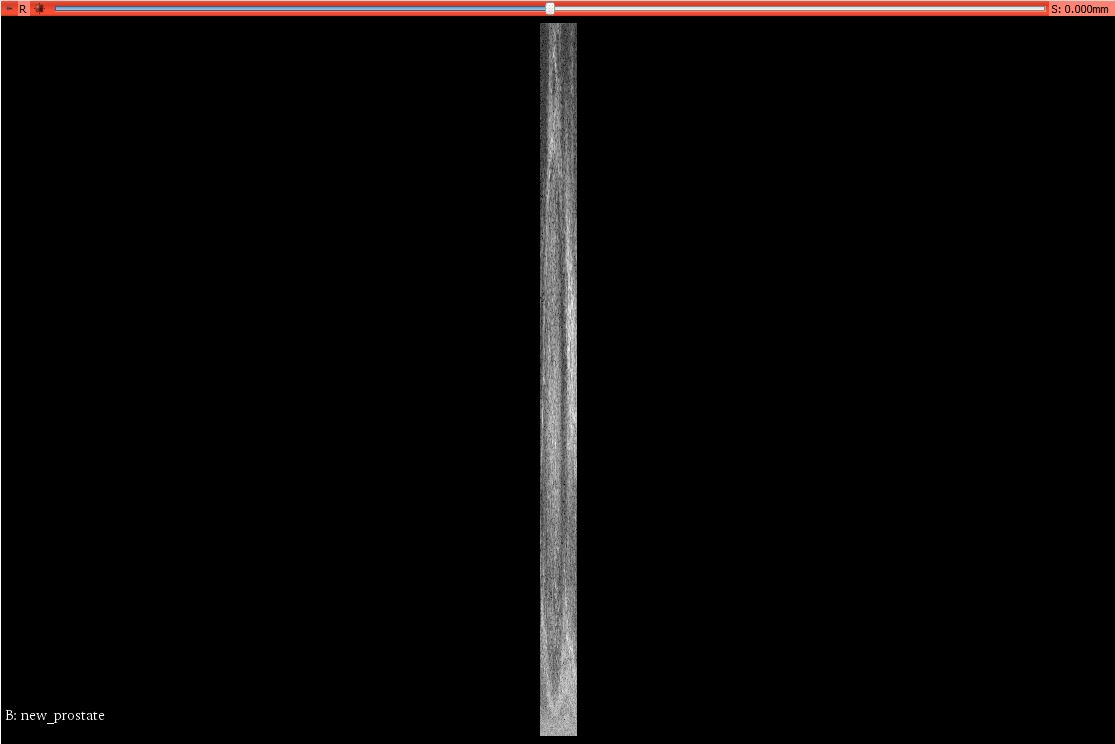

<h5>Part 1b</h5>

In [6]:
#read in metadata

df = pd.read_csv('meta_data.csv')

print(df)

          data_name  axial (mm)  lateral (mm)  grade     organ    modality
0  PCC-0312_LAL_GS7          28         46.08      7  prostate  ultrasound


<h5>Part 1c</h5>

In [7]:
def changeImageSpacing(image, axialExtent, lateralExtent):
    """
    Update the spacing for an image based on the desired axial and lateral extents and sizes
    :param image: image object 
    :param axialExtent: desired axial extent of an image in mm
    :param lateralExtent: desired lateral extent of an image in mm
    :return: image object with new spacing
    """
    axial_size = image.GetSize()[1]
    lateral_size = image.GetSize()[0]
    
    axial_spacing = axialExtent / axial_size
    lateral_spacing = lateralExtent / lateral_size
    
    image.SetSpacing((np.round(lateral_spacing, decimals = 3),np.round(axial_spacing, decimals = 3)))
    
    return image

In [8]:
#Get extents of axial and lateral dimensions
axial_extent = float(df['axial (mm)'])
lateral_extent = float(df['lateral (mm)'])

#Use physical extents and sizes of images to calculate image spacing
img_updated = changeImageSpacing(img, axial_extent, lateral_extent)

#Write new image
sitk.WriteImage(img_updated,"prostate_ultrasound.nrrd")

The ratio of the axial to lateral spacing reveals that the lateral dimension has much smaller pixels than the axial dimension.

<h5>Part 1d</h5>

In [9]:
img_p = readImage('prostate_ultrasound.nrrd')
img_p_name = "Prostate Ultrasound"

#View updated prostate ultrasound in 3D Slicer
#external_viewer.Execute(img_updated)
external_viewer.Execute(img_p)

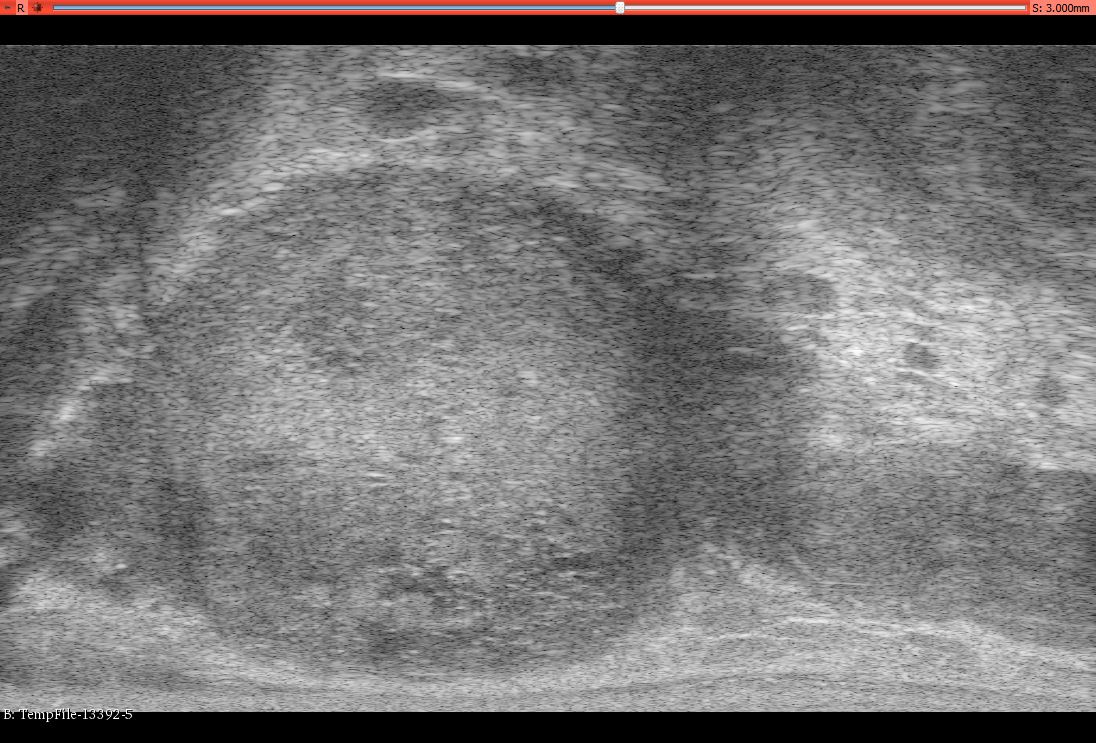

Although this is the same image that was visualized in part 1a, it appears much more sensical to the human eye. This is because the spacing of the image has been changed to match what the organ looks like in real life. Thus, we end up with a wider image, rather than a skinny, long one.

<h5>Part 1e</h5>

Segment image as viewed in 3D Slicer

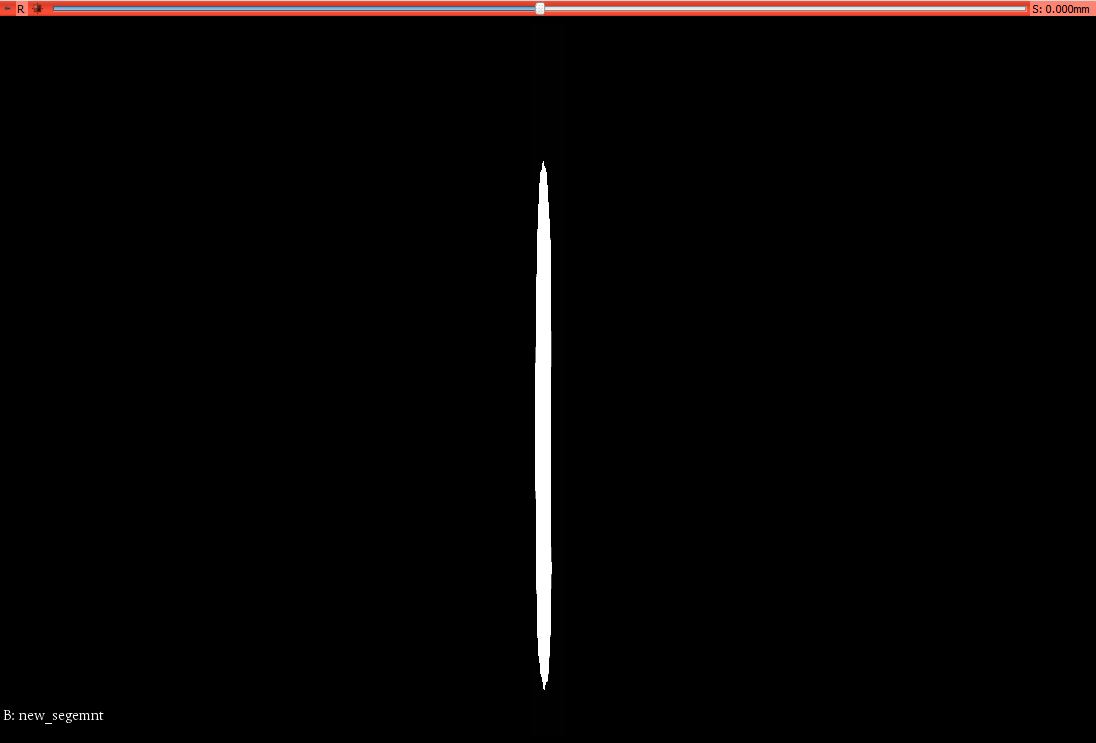

In [10]:
#Use physical extents and sizes of images to calculate image spacing
img2_updated = changeImageSpacing(img2, axial_extent, lateral_extent)

#Write new image
sitk.WriteImage(img2,"prostate_segment.nrrd")

#Import "nrrd" image
img_s = readImage('prostate_segment.nrrd')
img_s_name = "Prostate Segment"

#View updated prostate segment in 3D Slicer
external_viewer.Execute(img_s)

Segment image with updated spacing, as viewed in 3D Slicer

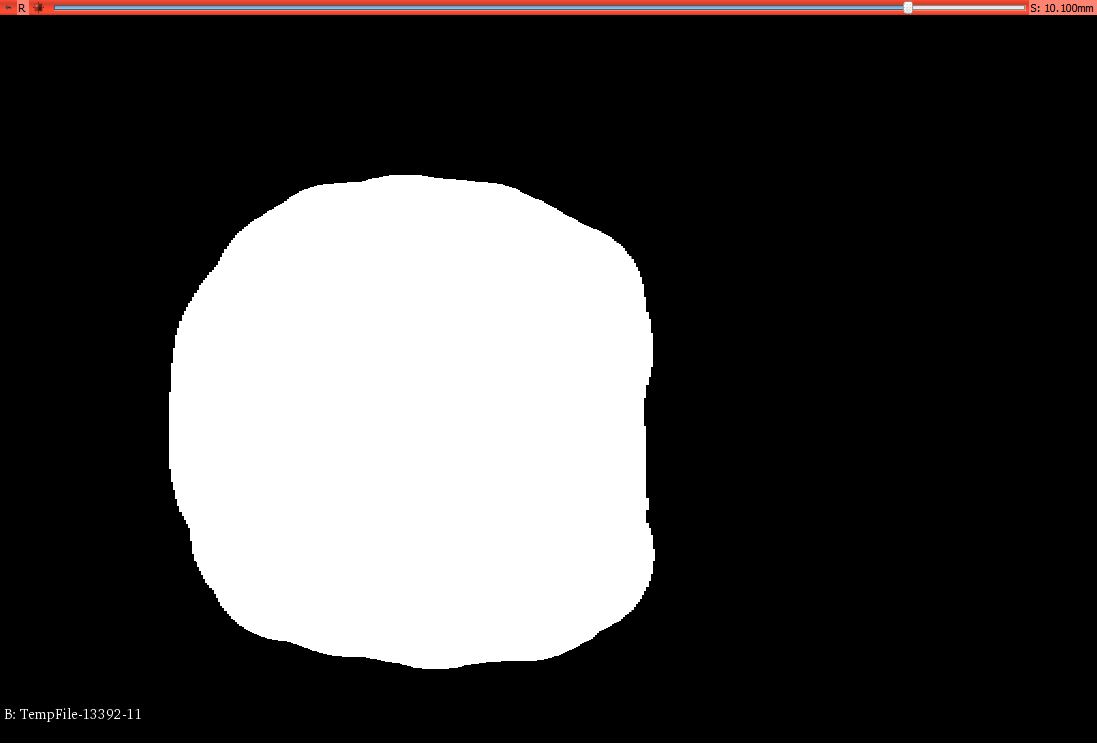

<h2>Part 2</h2>

<h5>Part 2a</h5>

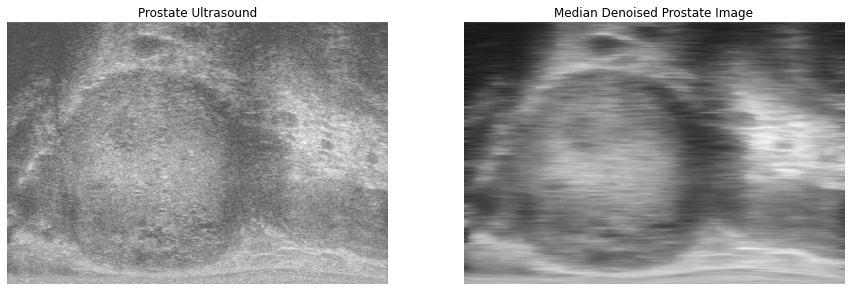

In [11]:
#employ median filter
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(14)

img_denoised = median_filter.Execute(img_p)


# visualize
plt.figure(figsize=(15,5))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(img_p), aspect = 0.035)
plt.axis('off')
plt.title(img_p_name)
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(img_denoised), aspect = 0.035) 
plt.axis('off')
plt.title('Median Denoised Prostate Image')
plt.show()

I explored different kernel sizes above. I started with a kernel size of 5, and incremented it by 5 until I reached 20, and the boundaries of the prostate were no longer clear. I then tried all values between 15-20, and chose 16 which appeared to have the best smoothing quality while still maintaining the important information from the image.

<h5>Part 2b</h5>

Text(0.5, 1.0, 'Denoised Prostate Image')

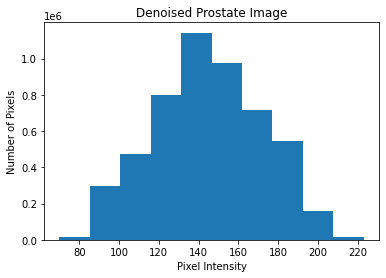

In [27]:
#Get image arrays for both images
img_denoised_array = sitk.GetArrayFromImage(img_denoised)

#Plot pixels in a histogram
plt.hist(img_denoised_array.flatten())
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.title("Denoised Prostate Image")

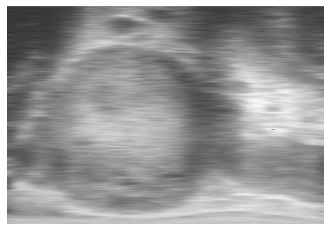

In [32]:
#Apply AdaptiveHistogramEquaalizationImageFilter
adapt_filter = sitk.AdaptiveHistogramEqualizationImageFilter()
adapt_filter.SetAlpha(10)
adapt_filter.SetBeta(1.5)
img_filtered = adapt_filter.Execute(img_denoised)

plt.imshow(sitk.GetArrayFromImage(img_filtered), aspect = 0.035)
plt.axis('off')
plt.show()


Text(0.5, 1.0, 'Filtered Prostate Image')

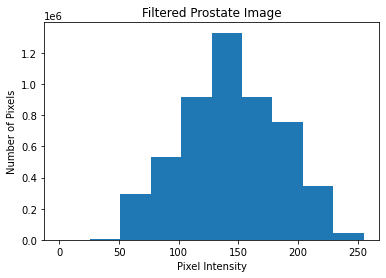

In [33]:
#Get image arrays for both images
img_filtered_array = sitk.GetArrayFromImage(img_filtered)

#Plot pixels in a histogram
plt.hist(img_filtered_array.flatten())
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.title("Filtered Prostate Image")

<h2>Part 3</h2>

<h5>Part 3a</h5>

In [ ]:
#View filtered prostate image in 3D Slicer
external_viewer.Execute(img_filtered)

sitk.WriteImage(img_filtered,"image_filtered.nrrd")

Range inside = 113 - 173
Range outside = 43 - 249

<h5>Part 3b</h5>

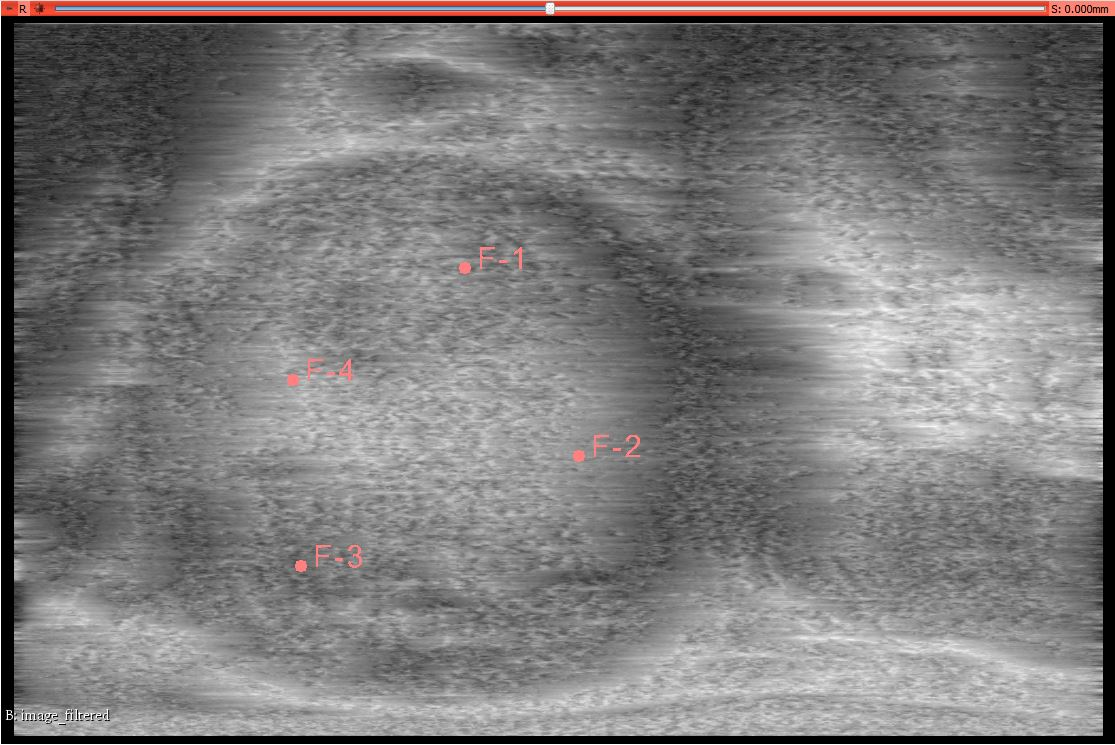

<b>LPS Coordinates</b>:<br>
Fiducial 1: 19.7, 10.9, 0<br>
Fiducial 2: 24.4, 19.0, 0<br>
Fiducial 3: 12.3, 23.8, 0<br>
Fiducial 4: 12.7, 15.1<br>

<h5>Part 3c</h5>

In [ ]:
#Apply ConfidenceConnected filter
Seed1 = (int(18.5), int(10.8), 0)
Seed2 = (int(20.9), int(18.2), 0)
Seed3 = (int(15.3), int(23.6), 0)
Seed4 = (int(11.7), int(15.2), 0)
SeedList = [Seed1,Seed2,Seed3,Seed4]

conf_filter = sitk.ConfidenceConnectedImageFilter()
conf_filter.SetSeedList(SeedList)
#conf_filter.SetSeedList([Seed4])
conf_filter.SetReplaceValue(255)
conf_filter.SetMultiplier(0.25)
conf_filter.SetInitialNeighborhoodRadius(100)
conf_filter.SetNumberOfIterations(10)
img_segmented = conf_filter.Execute(img_filtered)


plt.figure(figsize=(15,5))
#plt.gray()
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(img_segmented), aspect = 0.035)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(img_filtered), aspect = 0.035) 
plt.axis('off')
plt.show()

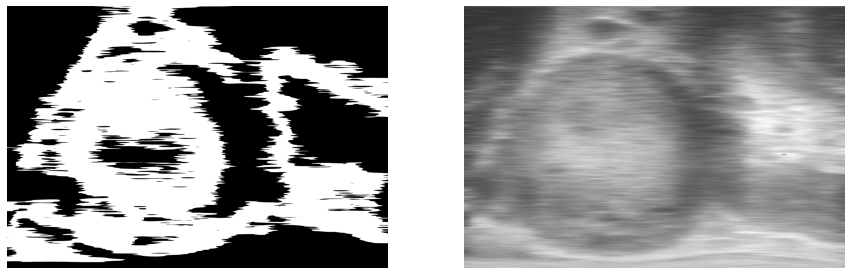

In [34]:
#Apply ConfidenceConnected filter

Seed1 = (188, 3319)
Seed2 = (220, 6607)
Seed3 = (142, 7795)
Seed4 = (187, 5368)
SeedList = [Seed1,Seed2,Seed3,Seed4]

conf_filter = sitk.ConfidenceConnectedImageFilter()
conf_filter.SetSeedList(SeedList)
#conf_filter.SetSeedList([Seed4])
conf_filter.SetReplaceValue(255)
conf_filter.SetMultiplier(1)
conf_filter.SetInitialNeighborhoodRadius(1)
conf_filter.SetNumberOfIterations(10)
img_segmented = conf_filter.Execute(img_filtered)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(img_segmented), aspect = 0.035)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(img_filtered), aspect = 0.035) 
plt.axis('off')
plt.show()

<h5>Part 3d</h5>

In [ ]:
# overlay the mask
img_overlay = sitk.LabelOverlay(img_filtered, img_segmented)

plt.imshow(sitk.GetArrayFromImage(img_overlay), aspect = 0.035)
plt.axis('off')
plt.show()

<h2>Part 4</h2>

<h5>Part 4a</h5>

In [ ]:
#Calculate area of the prostate
num_pixels = np.count_nonzero(img_s == 255)
A = num_pixels * img_s.GetSpacing()[0] * img_s.GetSpacing()[1]

print("The area of the prostate is: {} mm^2.".format(A))

<h5>Part 4b</h5>

In [ ]:
#Calculate volume of the prostate
c = 15

V = 4/3*A*c

print("The volume of the prostate is: {} mm^3.".format(V))

<h5>Part 4c</h5>

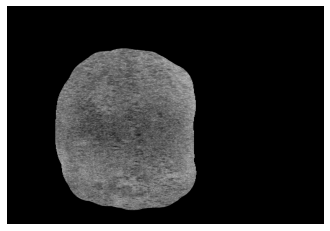

The average pixel intensity in the prostate region is: 108.82474786505898.
The standard deviation of the pixel intensity in the prostate region is: 24.08591951040388.


In [35]:
#Calculate mean and SD of pixel intensities inside the prostate region

#Create mask
img_masked = img_s * img_p
plt.imshow(sitk.GetArrayFromImage(img_masked), aspect = 0.035)
plt.axis('off')
plt.show()

#Calculate mean intensity of pixels in prostate region
img_pixels = sitk.GetArrayFromImage(img_masked) 
non_zero_img_pixels = img_pixels[img_pixels != 0]
pixel_mean = np.mean(non_zero_img_pixels)
print("The average pixel intensity in the prostate region is: {}.".format(pixel_mean))

#Calculate SD of pixel intensities in prostate region
pixel_sd = np.std(non_zero_img_pixels)
print("The standard deviation of the pixel intensity in the prostate region is: {}.".format(pixel_sd))